In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import spacy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_frame = pd.read_csv('IMDB Dataset.csv')
data_frame

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df = data_frame.copy()

In [4]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
df.shape

(50000, 2)

In [6]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df.duplicated().sum()

418

In [8]:
duplicated_rows = df[df.duplicated()]
duplicated_rows

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [9]:
df = df.drop_duplicates()

In [10]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [11]:
df.shape

(49582, 2)

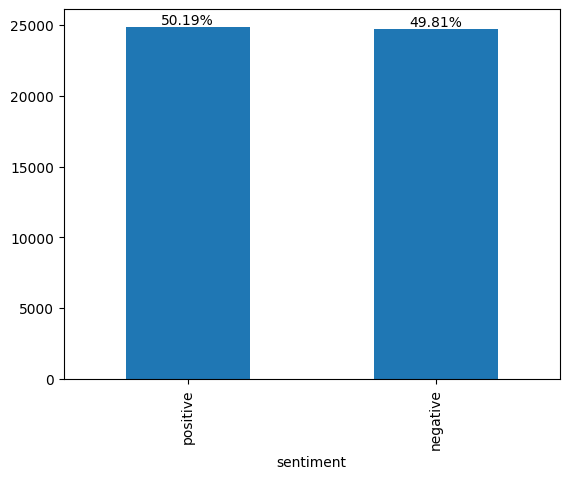

In [12]:
ax = df['sentiment'].value_counts().plot(kind='bar')
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    text = '{:.2f}%'.format(y / len(df) * 100)
    ax.text(x, y, text, ha='center', va='bottom', fontsize=10, color='black')
plt.show()

In [13]:
#text preprocessing
def lower_case(txt):
    return (txt.lower())
    
df['review'] = df['review'].apply(lower_case)

In [14]:
df['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

In [15]:
#word tokenization
def tokenize_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

In [16]:
data = df['review'].tolist()[:500]

In [17]:
data_words = list(tokenize_words(data))

In [18]:
#data_words[:1]

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
# higher threshold fewer phrases.
print('bigram',bigram)
print('bigram data',bigram[data_words])
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
print('trigram',trigram)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
bigram_mod.save("bigram_mod")
trigram_mod.save("trigram_mod")
bigram_mod = gensim.models.Phrases.load("bigram_mod")
trigram_mod = gensim.models.Phrases.load("trigram_mod")

bigram Phrases<81680 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
bigram data <gensim.interfaces.TransformedCorpus object at 0x7fbb0775f2b0>
trigram Phrases<81801 vocab, min_count=5, threshold=100, max_vocab_size=40000000>


In [20]:
for bigram in bigram_mod.phrasegrams.keys():
    print(bigram)

serial_killer
new_york
ve_seen
at_least
low_budget
year_old
reminds_me
ever_seen
high_school
special_effects
character_development
subject_matter
civil_war
cold_mountain
halfway_through
second_half
fast_forward
hong_kong
each_other
my_opinion
found_myself
years_ago
small_town
theme_song
rock_roll
star_trek
sit_through
sci_fi
huge_fan
jane_austen
anne_rice
new_world
pretty_woman
jackie_chan
throw_momma
gentleman_jim
ghost_stories
skeleton_dance
miss_dunne
bug_life


In [21]:
for trigram in trigram_mod.phrasegrams.keys():
    print(trigram)

serial_killer
looking_forward
ve_seen
at_least
low_budget
year_old
reminds_me
ever_seen
high_school
special_effects
character_development
subject_matter
civil_war
cold_mountain
second_half
fast_forward
each_other
my_opinion
in_my_opinion
found_myself
years_ago
small_town
theme_song
rock_roll
sit_through
huge_fan
jane_austen
anne_rice
new_world
pretty_woman
jackie_chan
throw_momma
gentleman_jim
ghost_stories
skeleton_dance
miss_dunne
bug_life


In [22]:
my_stop_words = STOPWORDS.union(set(['br']))
# Define functions for stopwords, bigrams, trigrams and lemmatisation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in my_stop_words] for doc in texts]

In [23]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [24]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
#data_words_nostops

In [25]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#data_words_bigrams

In [26]:
# Form Bigrams
data_words_trigrams = make_trigrams(data_words_bigrams)
#data_words_trigrams

In [27]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [29]:
print('data_lemmatized[:2]', data_lemmatized[:2])

data_lemmatized[:2] [['reviewer', 'mention', 'watch', 'episode', 'hook', 'right', 'exactly', 'happen', 'thing', 'strike', 'brutality', 'unflinche', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'faint', 'hearted', 'timid', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'call', 'nickname', 'give', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privacy', 'high', 'agenda', 'aryan', 'italian', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'far', 'away', 'main', 'appeal', 'fact', 'go', 'show', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'charm', 'forget', 'romance', 'mess', 'episode', 'see', 'strike', 'nasty', 'surreal', 'ready', 'watch', 'develop', 'taste', 'get', 'accustom', 'high', 'level', 'graphic', 'violence', 'violence', 'injustice', 'crook', 'guard', 'sell', 'nickel', 'inm

In [30]:
def getWordCloud(hashtags):
    # Read the whole text.
    text = ' '.join(hashtags)
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('wordcloud_all.pdf', dpi=500)
    plt.show()

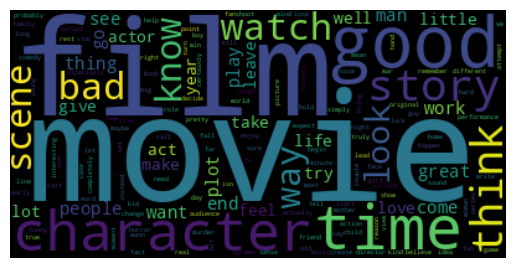

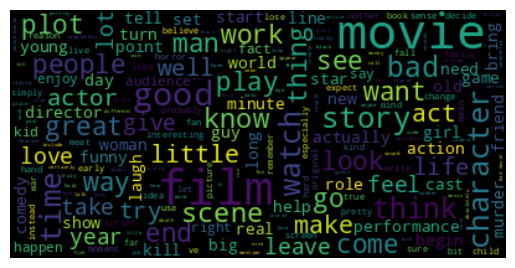

In [31]:
s = []
for l in data_lemmatized:
    t = ' '.join(l)
    s.append(t)
getWordCloud(s)

In [32]:
text_data = s

In [33]:
#models
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(text_data, df['sentiment'][:500], test_size=0.30, random_state=42)

In [34]:
# Vectorize the text data using CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_matrix = tfidf_vectorizer.fit_transform(X_train)
X_test_matrix = tfidf_vectorizer.transform(X_test)

In [35]:
tfidf_df = pd.DataFrame(X_train_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [36]:
tfidf_df.head(20)

,aaliyah,abandon,abbot,abbreviate,abedded,abet,abhorrent,abide,ability,abject,...,zellweger,zero,zinger,zip,zoey,zombie,zone,zoom,zucker,zulu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.136991,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [39]:
traditional_machine_learning_models = {
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machines': SVC(probability=True),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

In [40]:
# Evaluation metrics
def accuracy_measure(y_test, y_pred):
    return(format(accuracy_score(y_test, y_pred), '.4f'))

def classification_report_metric(y_test, y_pred):
    return(classification_report(y_test, y_pred))

def confusion_matrix_metric(y_test, y_pred):
    return(confusion_matrix(y_test, y_pred))

In [41]:
def train_model(name, model):
    evaluation_metrics = {}
    evaluation_metrics['name'] = name
    model.fit(X_train_matrix, y_train)
    y_pred = model.predict(X_test_matrix)
    y_prob = model.predict_proba(X_test_matrix)[:, 1]
    fpr, tpr, thresh = roc_curve(y_test_encoded, y_prob)
    roc_auc = auc(fpr, tpr)
    
    evaluation_metrics['accuracy_score'] = accuracy_measure(y_test, y_pred)
    evaluation_metrics['classification_report'] = classification_report_metric(y_test, y_pred)
    evaluation_metrics['confusion_matrix'] = confusion_matrix_metric(y_test, y_pred)
    evaluation_metrics['fpr'] = fpr
    evaluation_metrics['tpr'] = tpr
    evaluation_metrics['thresh'] = thresh
    evaluation_metrics['roc_auc'] = roc_auc

    return (evaluation_metrics)

In [42]:
def classification_report_to_df(report):
    report_data = []
    lines = [line.strip() for line in report.split('\n') if line.strip()]
    for i, line in enumerate(lines):
        if i == 0:
            continue
        words = [word.strip() for word in line.split('  ') if word]
    
        if len(words) < 5:
            words.append(words[1])
            words.append(words[2])
            words[1] = words[2] = ''
    
        report_data.append(words)
    data = pd.DataFrame([words[1:] for words in report_data], columns=['Precision', 'Recall', 'F1-Score', 'Support'], index=[words[0] for words in report_data])
    return(data)

In [43]:
#plot confusion matrix
def plot_confusion_matrix(ax, model):
    disp = ConfusionMatrixDisplay(confusion_matrix=model['confusion_matrix'], display_labels=['Negative', 'Positive'])
    plt.title(f"{model['name']} Confusion Matrix", fontsize=10)
    disp.plot(ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')

In [44]:
# Plot ROC curve
def plot_roc_curve(ax, model):
    ax.plot(model['fpr'], model['tpr'], color='red', lw=2, label=f'AUC = {model["roc_auc"]:.2f}')
    ax.plot([0, 1], [0, 1], color='green', linestyle='--')
    ax.set_xlim([0.0, 1.05])
    ax.set_ylim([0.0, 1.05])
    plt.title(f'{model["name"]} (ROC) Curve', fontsize=10)
    ax.legend(loc='lower right')
    ax.grid(True)

In [45]:
def subplot_graphs(x_label, y_label, title, graph_fun):
    fig= plt.figure(figsize=(11, 12))
    fig.text(0.5, 0.05, x_label, ha='center', va='center', fontsize=20)
    fig.text(0.05, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=20)
    fig.suptitle(title, fontsize=16)
    for i, model in enumerate(model_evaluations):
        ax = fig.add_subplot(3, 2, i + 1)
        graph_fun(ax, model)
    
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.show()

In [46]:
model_evaluations = []
for name, model in traditional_machine_learning_models.items():
    model_evaluations.append(train_model(name, model))

In [47]:
accuracy_score_df = pd.DataFrame([(model['name'], model['accuracy_score']) for model in model_evaluations], columns=['model','accuracy_score'])
accuracy_score_df

,model,accuracy_score
0,Naive Bayes,0.6400
1,Support Vector Machines,0.7467
2,Logistic Regression,0.7600
3,Decision Tree,0.6533
4,Random Forest,0.7200


In [48]:
class_report = [classification_report_to_df(report['classification_report']) for report in model_evaluations]
class_report_df = pd.concat(class_report, keys=[model['name'] for model in model_evaluations])
class_report_df

Precision Recall F1-Score Support
Naive Bayes             negative          0.58   0.96     0.72      73
                        positive          0.90   0.34     0.49      77
                        accuracy                          0.64     150
                        macro avg         0.74   0.65     0.61     150
                        weighted avg      0.74   0.64     0.60     150
Support Vector Machines negative          0.67   0.96     0.79      73
                        positive          0.93   0.55     0.69      77
                        accuracy                          0.75     150
                        macro avg         0.80   0.75     0.74     150
                        weighted avg      0.80   0.75     0.74     150
Logistic Regression     negative          0.69   0.93     0.79      73
                        positive          0.90   0.60     0.72      77
                        accuracy                          0.76     150
                        macro avg         0.79   0.76     0.75     150
                        weighted avg      0.80   0.76     0.75     150
Decision Tree           negative          0.64   0.64     0.64      73
                        positive          0.66   0.66     0.66      77
                        accuracy                          0.65     150
                        macro avg         0.65   0.65     0.65     150
                        weighted avg      0.65   0.65     0.65     150
Random Forest           negative          0.65   0.90     0.76      73
                        positive          0.86   0.55     0.67      77
                        accuracy                          0.72     150
                        macro avg         0.76   0.72     0.71     150
                        weighted avg      0.76   0.72     0.71     150

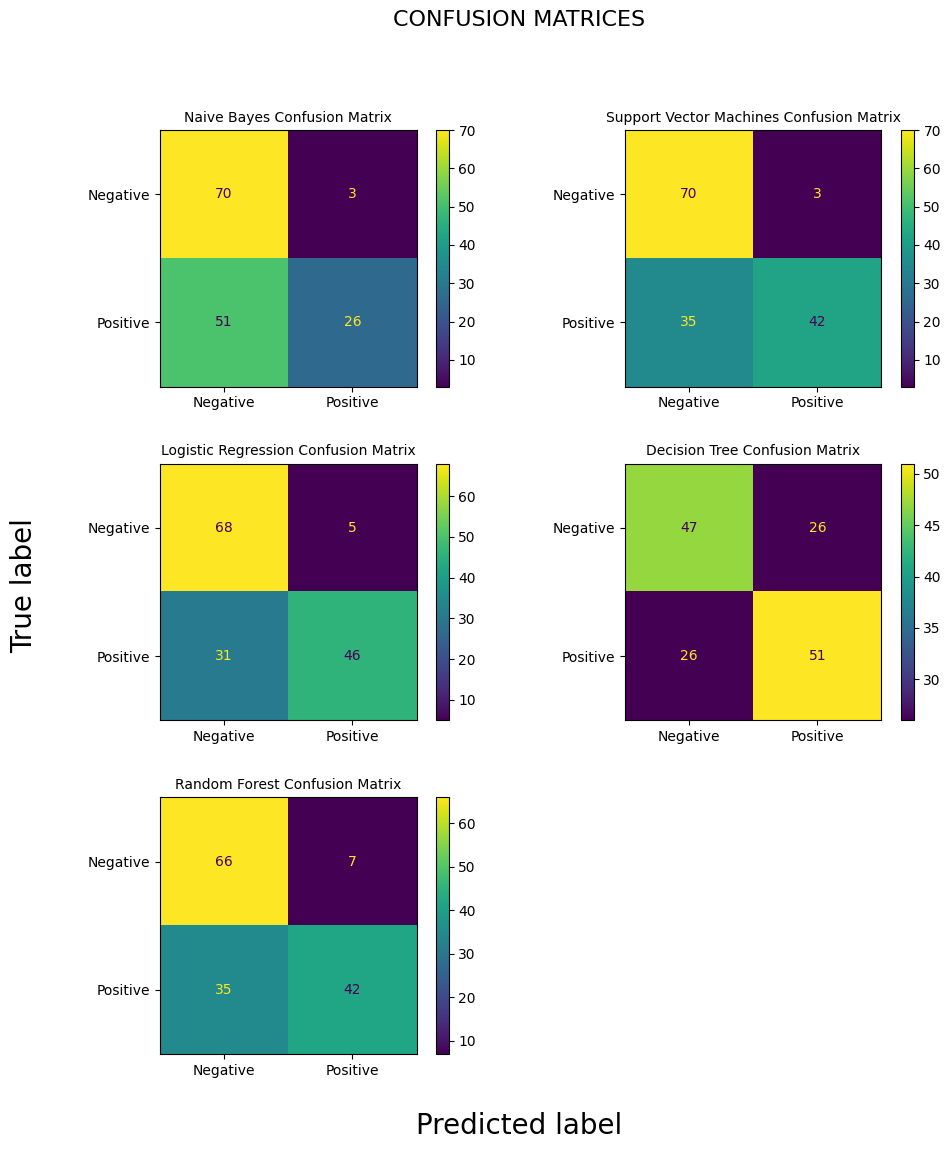

In [49]:
subplot_graphs( 'Predicted label', 'True label', 'CONFUSION MATRICES', plot_confusion_matrix)

In [50]:
roc_auc_df = pd.DataFrame([(model['name'], model['roc_auc']) for model in model_evaluations], columns=['model','roc_auc'])
roc_auc_df

,model,roc_auc
0,Naive Bayes,0.882405
1,Support Vector Machines,0.893969
2,Logistic Regression,0.891300
3,Decision Tree,0.653087
4,Random Forest,0.868440


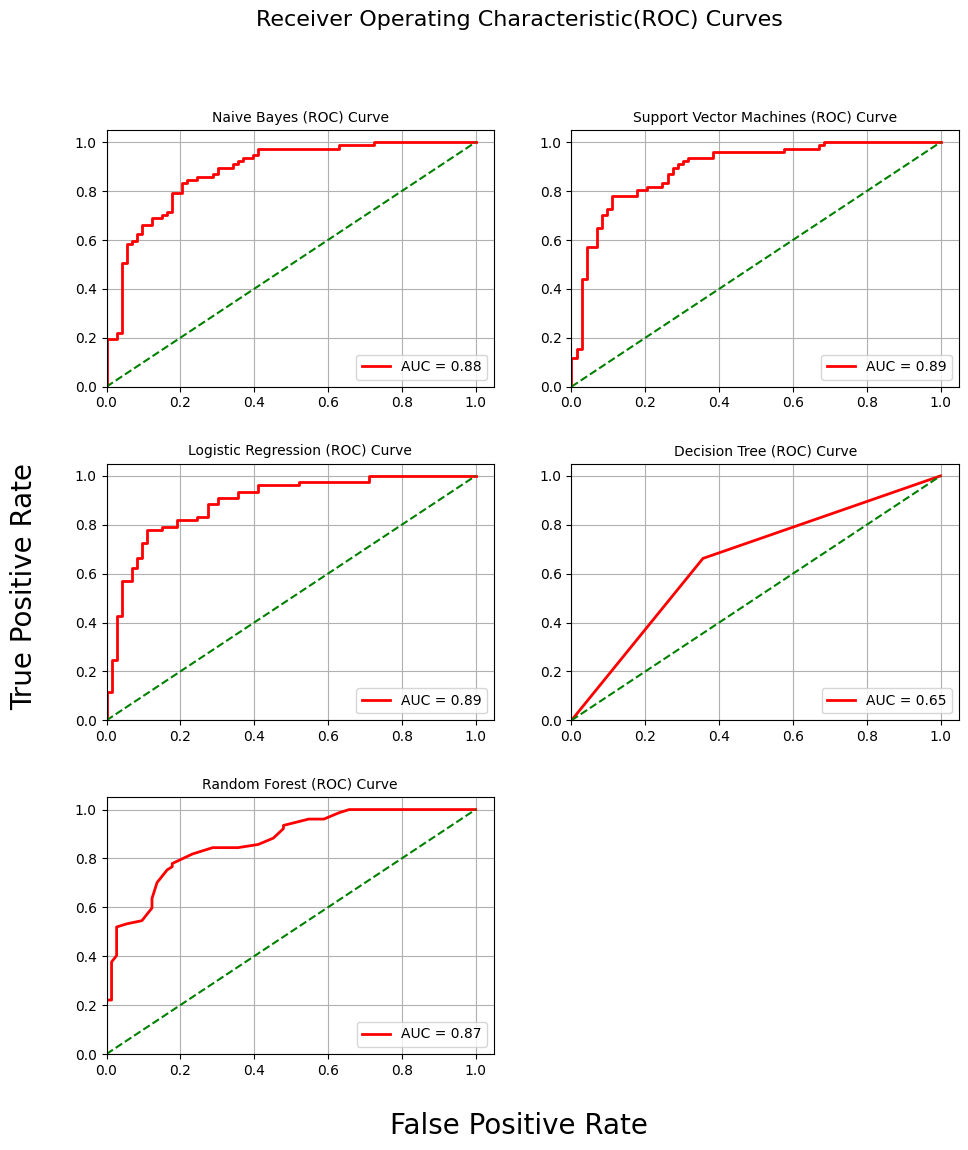

In [51]:
subplot_graphs('False Positive Rate', 'True Positive Rate', 'Receiver Operating Characteristic(ROC) Curves', plot_roc_curve)

### Deep Learning Models